# Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

# Import stuff

In [1]:
import sys
sys.path.append("..")
import grading
import download_utils

import tensorflow as tf
import keras, keras.layers as L
s = keras.backend.get_session()

import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset

%matplotlib inline
import matplotlib.pyplot as plt

download_utils.link_week_4_resources()

X, attr = load_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.astype('float32') / 255.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

Using TensorFlow backend.


HBox(children=(IntProgress(value=0, max=18983), HTML(value='')))

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset

# Load dataset
Dataset was downloaded for you. Relevant links (just in case):
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [3]:
# we downloaded them for you, just link them here
download_utils.link_week_4_resources()

In [4]:
X, attr = load_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.astype('float32') / 255.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

HBox(children=(IntProgress(value=0, max=18983), HTML(value='')))

X shape: (13143, 38, 38, 3)
attr shape: (13143, 73)


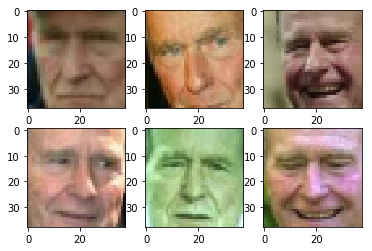

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as two sequential keras models: the encoder and decoder respectively.

We will then use symbolic API to apply and train those models.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



In [6]:
import tensorflow as tf
import keras, keras.layers as L
s = keras.backend.get_session()

## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [7]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1))
    plt.show()

def train_autoencoder(encoder, decoder):
    inp = L.Input(img_shape)
    code = encoder(inp)
    reconstruction = decoder(code)

    autoencoder = keras.models.Model(inp,reconstruction)
    autoencoder.compile('adamax','mse')

    autoencoder.fit(x=X_train,y=X_train,epochs=32,batch_size=32,
                    validation_data=[X_test,X_test], verbose=True)
    return autoencoder

def visualize_autoencoder(encoder, decoder, autoencoder):
    score = autoencoder.evaluate(X_test,X_test,verbose=0)
    print("Final MSE:",score)

    for i in range(5):
        img = X_test[i]
        visualize(img,encoder,decoder)


Let's build a first autoencoder with just a single Dense layer.

In [ ]:
def build_pca_autoencoder(img_shape,code_size=32):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

encoder,decoder = build_pca_autoencoder(img_shape,code_size=32)
autoencoder = train_autoencoder(encoder, decoder)
visualize_autoencoder(encoder, decoder, autoencoder)


Let's try an autoencoder with a linear activation and an l1 regularizer.

In [ ]:
def build_pca_autoencoder_2(img_shape,code_size=32):
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size, activation='linear',
                       activity_regularizer=keras.regularizers.l1(10e-9)))

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

encoder,decoder = build_pca_autoencoder_2(img_shape,code_size=32)
autoencoder = train_autoencoder(encoder, decoder)

In [ ]:
visualize_autoencoder(encoder, decoder, autoencoder)

In [ ]:
def build_pca_autoencoder_3(img_shape,code_size=32):
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    activation = 'linear'
    encoder.add(L.Dense(256, activation=activation))
    encoder.add(L.Dense(128, activation=activation))
    encoder.add(L.Dense(64, activation=activation))
    encoder.add(L.Dense(code_size, activation=activation))
                       

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    decoder.add(L.Dense(64, activation=activation))
    decoder.add(L.Dense(128, activation=activation))
    decoder.add(L.Dense(256, activation=activation))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

encoder,decoder = build_pca_autoencoder_3(img_shape,code_size=32)
autoencoder = train_autoencoder(encoder, decoder)


In [ ]:
visualize_autoencoder(encoder, decoder, autoencoder)

### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [ ]:
def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    conv_filters = 50
    hidden_size = code_size * 4
    conv1 = L.Conv2D(conv_filters, (3,3), activation='relu')
    encoder.add(conv1)
    conv1_shape = conv1.output_shape
 
    flat1 = L.Flatten()
    encoder.add(flat1)                  #flatten image to vector
    encoder.add(L.Dense(hidden_size, activation='relu'))
    encoder.add(L.Dense(hidden_size, activation='relu'))

    encoder.add(L.Dense(code_size))
    
    
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    decoder.add(L.Dense(hidden_size, activation='relu'))
    decoder.add(L.Dense(hidden_size, activation='relu'))
    dense2 = L.Dense(np.prod(conv1_shape[1:]))
    decoder.add(dense2)
    decoder.add(L.Reshape(conv1_shape[1:]))
    deconv1 = L.Deconv2D(3, (3,3))
    decoder.add(deconv1)
    
    decoder.add(L.Reshape(img_shape)) 
    
    return encoder,decoder

print(img_shape)
build_deep_autoencoder(img_shape, code_size=32)

In [ ]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    encoder,decoder = build_deep_autoencoder(img_shape,code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==img_shape,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 dense layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 dense layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")

__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [ ]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

Training may take some 20 minutes.

In [ ]:
X_train.shape

In [ ]:
autoencoder.fit(x=X_train,y=X_train,epochs=64,batch_size=32,
                validation_data=[X_test,X_test])

In [ ]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("Final MSE:",score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)



In [ ]:
s.close()

In [ ]:
K.clear_session()

In [59]:
import keras.backend as K
from keras import regularizers

def test_autoencoder(encoder, decoder): #Check autoencoder shapes along different code_sizes
    get_dim = lambda layer: np.prod(layer.output_shape[1:])
    for code_size in [1,8,32,128,512,1024]:
        encoder,decoder = build_deep_autoencoder(img_shape,code_size=code_size)
        print("Testing code size %i" % code_size)
        assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
        assert decoder.output_shape[1:]==img_shape,   "decoder must output an image of valid shape"
        assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 dense layers"
        assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 dense layers"

        for layer in encoder.layers + decoder.layers:
            assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

    print("All tests passed!")

def train_deep_autoencoder(encoder, decoder, epochs=64, batch_size=32, autoencoder=None):
    inp = L.Input(img_shape)
    code = encoder(inp)
    reconstruction = decoder(code)
    if autoencoder is None:
        autoencoder = keras.models.Model(inp,reconstruction)
        autoencoder.compile('adamax','mse')

    autoencoder.fit(x=X_train,y=X_train,epochs=epochs,batch_size=batch_size,
                    validation_data=[X_test,X_test])
    
    return autoencoder


class AutoEncoder():
    def __init__(self, img_shape, code_size=32):
        self.code_size = code_size
        self.img_shape = img_shape
        
        self.encoder = keras.models.Sequential()
        self.input_node = L.InputLayer(self.img_shape)
        self.encoder.add(self.input_node)

        self.decoder = keras.models.Sequential()
        self.decoder.add(L.InputLayer((self.code_size,)))

        self.decoder_layers = [L.Reshape(self.img_shape)]
        
        self.prev_filters = 3
        self.last_encoder_node = self.input_node
        
        self.auto_encoder = None
        
        self.finished = False


    def add_conv_layer(self, filters, size, encoder_activation='relu', decoder_activation='linear'):
        assert not self.finished
        conv = L.Conv2D(filters, (size, size), activation=encoder_activation)
        self.encoder.add(conv)
        self.last_encoder_node = conv
        self.decoder_layers.append(L.Deconv2D(self.prev_filters, (size, size), activation=decoder_activation))
        self.prev_filters = filters
        return conv
        
    def add_max_pool(self):
        assert not self.finished
        maxpool2d = L.MaxPooling2D((2,2))
        self.encoder.add(maxpool2d)
        self.last_encoder_node = maxpool2d
        self.decoder_layers.append(L.UpSampling2D((2,2)))
        return maxpool2d
    
    def add_dense(self,
                  size, 
                  encoder_activation='relu', 
                  decoder_activation='linear',
                 activity_regularizer=None):
        assert not self.finished
        dense = L.Dense(size, activation=encoder_activation,
                       activity_regularizer=activity_regularizer)
        self.encoder.add(dense)
        self.last_encoder_node = dense
        self.decoder_layers.append(L.Dense(dense.input_shape[1], activation=decoder_activation))
        
    def add_flatten(self):
        assert not self.finished
        flat1 = L.Flatten()
        self.encoder.add(flat1)
        self.decoder_layers.append(L.Reshape(self.last_encoder_node.output_shape[1:]))        
        
    def finish(self):
        assert not self.finished
        for layer in reversed(self.decoder_layers):
            print("Adding layer", layer)
            self.decoder.add(layer)
            
        self.finished = True
        return self.encoder, self.decoder
    
    def train(self, epochs=64, batch_size=32):
        if not self.finished:
            self.finish()
            
        inp = L.Input(self.img_shape)
        code = self.encoder(inp)
        reconstruction = self.decoder(code)
        
        if self.auto_encoder is None:
            self.auto_encoder = keras.models.Model(inp, reconstruction)
            self.auto_encoder.compile('adamax','mse')

        self.auto_encoder.fit(x=X_train,y=X_train,epochs=epochs,batch_size=batch_size,
                        validation_data=[X_test,X_test])

        return self.auto_encoder   
    
    def visualize(self):
        visualize_autoencoder(self.encoder, self.decoder, self.auto_encoder)
        


Adding layer <keras.layers.core.Dense object at 0x7f8ec4046160>
Adding layer <keras.layers.core.Dense object at 0x7f8ec4038eb8>
Adding layer <keras.layers.core.Dense object at 0x7f8ec540a518>
Adding layer <keras.layers.core.Reshape object at 0x7f8ec53d2710>
Adding layer <keras.layers.core.Reshape object at 0x7f8ec53d2518>
Adding layer <keras.layers.core.Dense object at 0x7f8ea19cbf60>
Adding layer <keras.layers.core.Dense object at 0x7f8ec403cef0>
Adding layer <keras.layers.core.Dense object at 0x7f8ec568b4a8>
Adding layer <keras.layers.core.Reshape object at 0x7f8ec567ef60>
Adding layer <keras.layers.core.Reshape object at 0x7f8ec567e860>
Testing code size 1
Adding layer <keras.layers.core.Dense object at 0x7f8ea05357b8>
Adding layer <keras.layers.core.Dense object at 0x7f8ea0523198>
Adding layer <keras.layers.core.Dense object at 0x7f8ea0577668>
Adding layer <keras.layers.core.Reshape object at 0x7f8ea0562908>
Adding layer <keras.layers.core.Reshape object at 0x7f8ea054e7b8>
Testing 

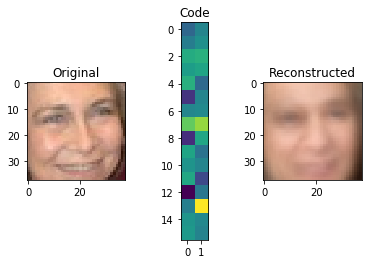

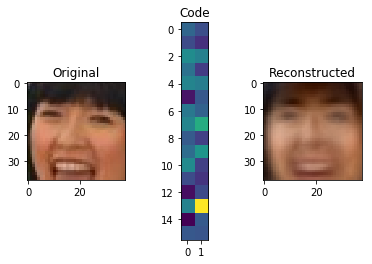

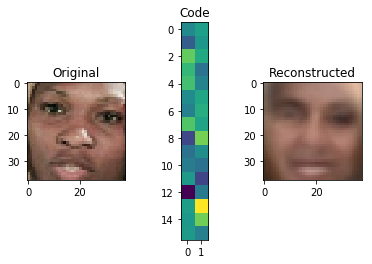

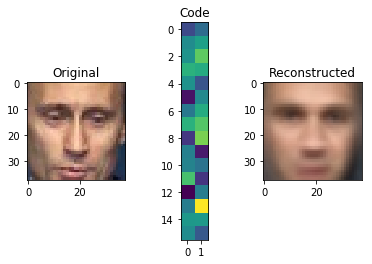

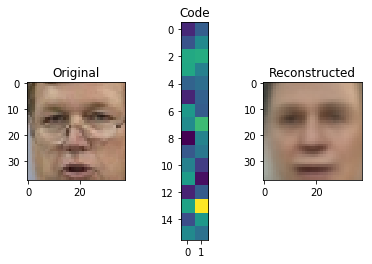

In [56]:

s.close()
s = tf.Session()
K.set_session(s)

def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    
    encoder = keras.models.Sequential()
    input_node = L.InputLayer(img_shape)
    encoder.add(input_node)

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    decoder_layers = [L.Reshape(img_shape)]

    conv_filters = 32
    hidden_size = code_size * 2
    
    prev_filters = 3
    last_encoder_node = input_node
    
    def add_dense(size, 
                  encoder_activation='relu', 
                  decoder_activation='relu',
                 activity_regularizer=None):
        nonlocal prev_filters
        nonlocal last_encoder_node

        dense = L.Dense(size, activation=encoder_activation,
                       activity_regularizer=activity_regularizer)
        encoder.add(dense)
        last_encoder_node = dense
        decoder_layers.append(L.Dense(dense.input_shape[1], activation=decoder_activation))
        
            
    flat1 = L.Flatten()
    encoder.add(flat1)
    decoder_layers.append(L.Reshape(last_encoder_node.output_shape[1:]))

    add_dense(code_size * 4, decoder_activation='linear', encoder_activation='linear')
    add_dense(code_size * 2, decoder_activation='linear', encoder_activation='linear')
    add_dense(code_size, decoder_activation='linear', encoder_activation='linear')

    for layer in reversed(decoder_layers):
        print("Adding layer", layer)
        decoder.add(layer)
    
    return encoder,decoder

encoder,decoder = build_deep_autoencoder(img_shape,code_size=32)

test_autoencoder(encoder, decoder)
autoencoder = train_deep_autoencoder(encoder, decoder, epochs=32)
visualize_autoencoder(encoder, decoder, autoencoder)

Adding layer <keras.layers.core.Dense object at 0x7f8e9b908470>
Adding layer <keras.layers.core.Dense object at 0x7f8e9b8cce48>
Adding layer <keras.layers.core.Dense object at 0x7f8ec53e66a0>
Adding layer <keras.layers.core.Reshape object at 0x7f8ec604ae48>
Adding layer <keras.layers.core.Reshape object at 0x7f8ec5447b70>
Train on 11828 samples, validate on 1315 samples
Epoch 1/32
11828/11828 [==============================] - 5s 392us/step - loss: 0.0371 - val_loss: 0.0192
Epoch 2/32
11828/11828 [==============================] - 3s 249us/step - loss: 0.0172 - val_loss: 0.0151
Epoch 3/32
11828/11828 [==============================] - 3s 242us/step - loss: 0.0141 - val_loss: 0.0129
Epoch 4/32
11828/11828 [==============================] - 3s 240us/step - loss: 0.0123 - val_loss: 0.0116
Epoch 5/32
11828/11828 [==============================] - 3s 241us/step - loss: 0.0111 - val_loss: 0.0105
Epoch 6/32
11828/11828 [==============================] - 3s 239us/step - loss: 0.0102 - val_loss

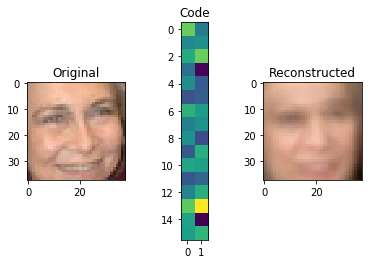

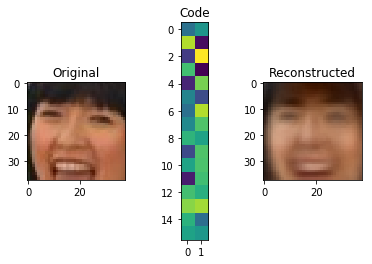

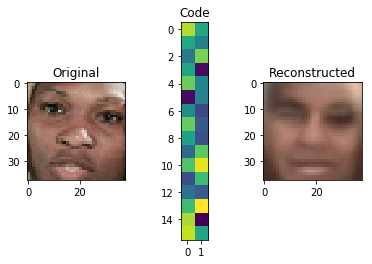

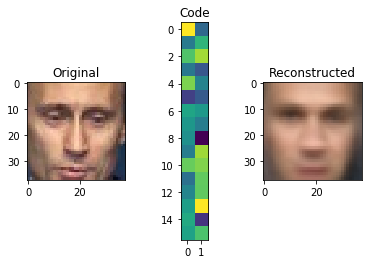

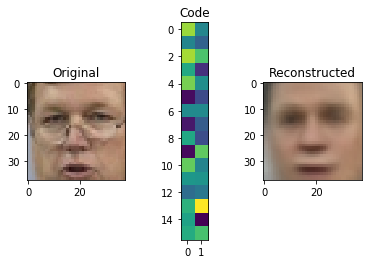

In [57]:
code_size = 32
simple_auto_encoder = AutoEncoder(img_shape=img_shape, code_size=code_size)
simple_auto_encoder.add_flatten()
simple_auto_encoder.add_dense(code_size * 4, decoder_activation='linear', encoder_activation='linear')
simple_auto_encoder.add_dense(code_size * 2, decoder_activation='linear', encoder_activation='linear')
simple_auto_encoder.add_dense(code_size, decoder_activation='linear', encoder_activation='linear')

simple_auto_encoder.train(epochs=32)
simple_auto_encoder.visualize()

It seems that the relu activation, at least on the encoder, produces these weird red and green dots. Let's try again with a linear encoder activation, and a relu decoder activation.

Adding layer <keras.layers.core.Dense object at 0x7f8e9bac6b38>
Adding layer <keras.layers.core.Dense object at 0x7f8e9baf1828>
Adding layer <keras.layers.core.Dense object at 0x7f8e9b8d3d30>
Adding layer <keras.layers.core.Reshape object at 0x7f8e9b9554e0>
Adding layer <keras.layers.core.Reshape object at 0x7f8e9b955550>
Train on 11828 samples, validate on 1315 samples
Epoch 1/16
11828/11828 [==============================] - 5s 460us/step - loss: 0.0743 - val_loss: 0.0552
Epoch 2/16
11828/11828 [==============================] - 3s 248us/step - loss: 0.0485 - val_loss: 0.0431
Epoch 3/16
11828/11828 [==============================] - 3s 247us/step - loss: 0.0391 - val_loss: 0.0359
Epoch 4/16
11828/11828 [==============================] - 3s 248us/step - loss: 0.0332 - val_loss: 0.0309
Epoch 5/16
11828/11828 [==============================] - 3s 248us/step - loss: 0.0286 - val_loss: 0.0260
Epoch 6/16
11828/11828 [==============================] - 3s 250us/step - loss: 0.0241 - val_loss

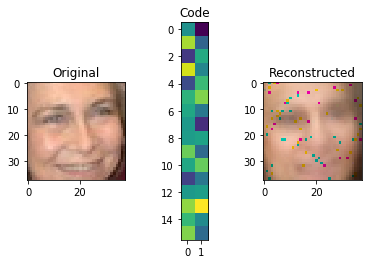

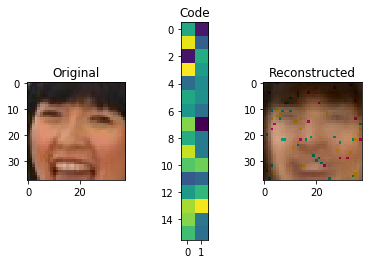

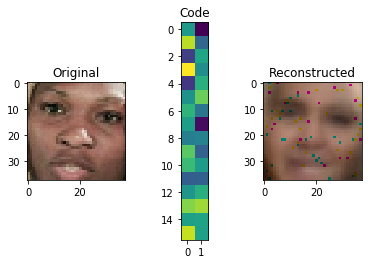

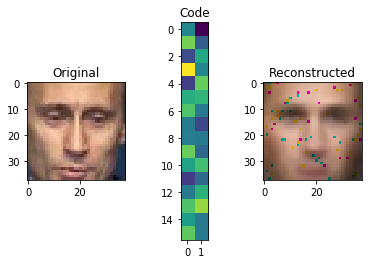

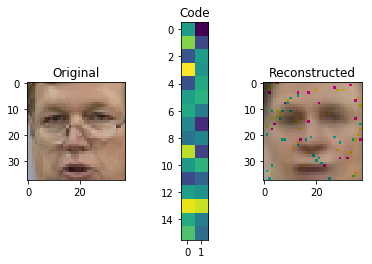

In [58]:
s.close()
s = tf.Session()
K.set_session(s)

code_size = 32
relu_test_auto_encoder = AutoEncoder(img_shape=img_shape, code_size=code_size)
relu_test_auto_encoder.add_flatten()
relu_test_auto_encoder.add_dense(code_size * 4, decoder_activation='relu', encoder_activation='linear')
relu_test_auto_encoder.add_dense(code_size * 2, decoder_activation='relu', encoder_activation='linear')
relu_test_auto_encoder.add_dense(code_size, decoder_activation='relu', encoder_activation='linear')

relu_test_auto_encoder.train(epochs=16)
relu_test_auto_encoder.visualize()

As we can see, indeed the relu activation of the decoder leads to the red and green dots. Let's check to see if the relu in the encoder network has the same effect.

Adding layer <keras.layers.core.Dense object at 0x7f8e9aa17c88>
Adding layer <keras.layers.core.Dense object at 0x7f8e9aa5a748>
Adding layer <keras.layers.core.Dense object at 0x7f8e9bb1f630>
Adding layer <keras.layers.core.Reshape object at 0x7f8e9bb248d0>
Adding layer <keras.layers.core.Reshape object at 0x7f8e9bb249e8>
Train on 11828 samples, validate on 1315 samples
Epoch 1/16
11828/11828 [==============================] - 5s 463us/step - loss: 0.0220 - val_loss: 0.0149
Epoch 2/16
11828/11828 [==============================] - 3s 254us/step - loss: 0.0138 - val_loss: 0.0127
Epoch 3/16
11828/11828 [==============================] - 3s 252us/step - loss: 0.0125 - val_loss: 0.0119
Epoch 4/16
11828/11828 [==============================] - 3s 255us/step - loss: 0.0115 - val_loss: 0.0108
Epoch 5/16
11828/11828 [==============================] - 3s 259us/step - loss: 0.0109 - val_loss: 0.0106
Epoch 6/16
11828/11828 [==============================] - 3s 253us/step - loss: 0.0106 - val_loss

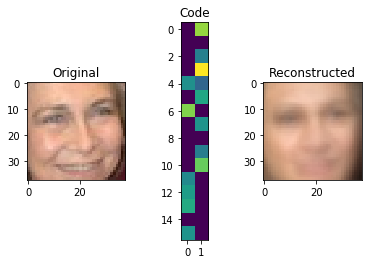

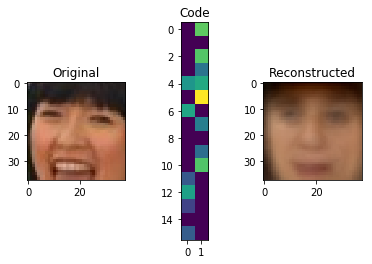

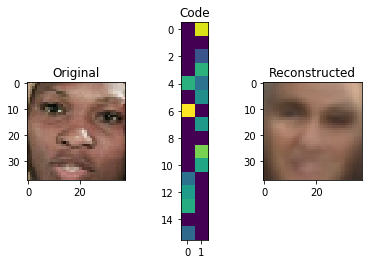

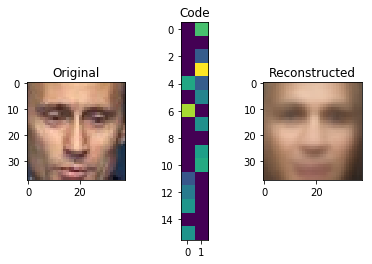

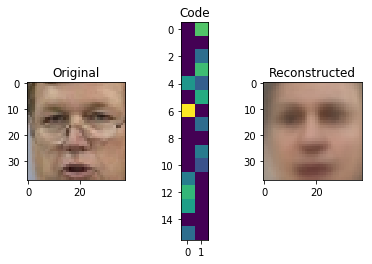

In [60]:
s.close()
s = tf.Session()
K.set_session(s)

code_size = 32
relu_test_auto_encoder = AutoEncoder(img_shape=img_shape, code_size=code_size)
relu_test_auto_encoder.add_flatten()
relu_test_auto_encoder.add_dense(code_size * 4, decoder_activation='linear', encoder_activation='relu')
relu_test_auto_encoder.add_dense(code_size * 2, decoder_activation='linear', encoder_activation='relu')
relu_test_auto_encoder.add_dense(code_size, decoder_activation='linear', encoder_activation='relu')

relu_test_auto_encoder.train(epochs=16)
relu_test_auto_encoder.visualize()

As we can see, using relu in the encoder is just fine.

Let's try adding some convolutional layers.

last img output shape:  (None, 3, 3, 8)
Adding layer <keras.layers.core.Dense object at 0x7f8e9996c898>
Adding layer <keras.layers.core.Dense object at 0x7f8e99947ac8>
Adding layer <keras.layers.core.Reshape object at 0x7f8e99947128>
Adding layer <keras.layers.convolutional.UpSampling2D object at 0x7f8e999b67f0>
Adding layer <keras.layers.convolutional.Conv2DTranspose object at 0x7f8e99abe4e0>
Adding layer <keras.layers.convolutional.UpSampling2D object at 0x7f8e999e4240>
Adding layer <keras.layers.convolutional.Conv2DTranspose object at 0x7f8e99a386d8>
Adding layer <keras.layers.convolutional.UpSampling2D object at 0x7f8e99a30fd0>
Adding layer <keras.layers.convolutional.Conv2DTranspose object at 0x7f8e99a18a90>
Adding layer <keras.layers.core.Reshape object at 0x7f8e99a187f0>
Train on 11828 samples, validate on 1315 samples
Epoch 1/16
11828/11828 [==============================] - 7s 589us/step - loss: 0.0389 - val_loss: 0.0232
Epoch 2/16
11828/11828 [==============================] 

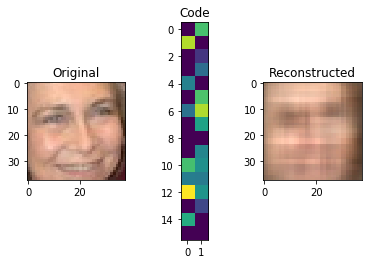

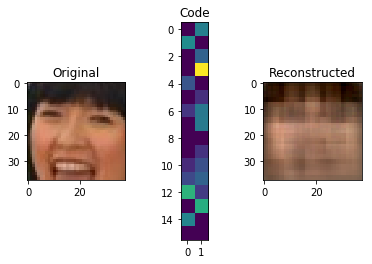

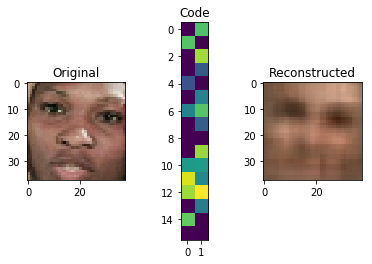

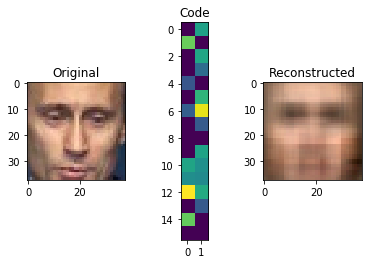

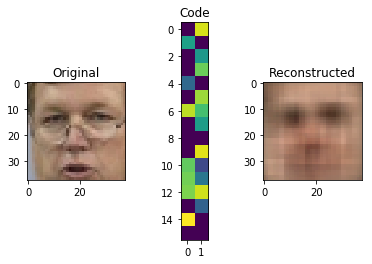

In [61]:
s.close()
s = tf.Session()
K.set_session(s)

code_size=32

auto_encoder = AutoEncoder(img_shape=img_shape, code_size=code_size)

auto_encoder.add_conv_layer(16, size=3)
auto_encoder.add_max_pool()
auto_encoder.add_conv_layer(8, size=3)
auto_encoder.add_max_pool()
auto_encoder.add_conv_layer(8, size=3)
auto_encoder.add_max_pool()

print("last img output shape: ", auto_encoder.last_encoder_node.output_shape)

auto_encoder.add_flatten()
hidden_size = code_size * 4

# auto_encoder.add_dense(hidden_size, activity_regularizer=regularizers.l1(10e-5))
# auto_encoder.add_dense(hidden_size, activity_regularizer=regularizers.l1(10e-5))

auto_encoder.add_dense(128)
auto_encoder.add_dense(code_size)

auto_encoder.train(epochs=16)
auto_encoder.visualize()


Train on 11828 samples, validate on 1315 samples
Epoch 1/32
11828/11828 [==============================] - 5s 426us/step - loss: 0.0113 - val_loss: 0.0112
Epoch 2/32
11828/11828 [==============================] - 4s 374us/step - loss: 0.0112 - val_loss: 0.0111
Epoch 3/32
11828/11828 [==============================] - 4s 368us/step - loss: 0.0111 - val_loss: 0.0110
Epoch 4/32
11828/11828 [==============================] - 4s 372us/step - loss: 0.0110 - val_loss: 0.0110
Epoch 5/32
11828/11828 [==============================] - 4s 370us/step - loss: 0.0109 - val_loss: 0.0108
Epoch 6/32
11828/11828 [==============================] - 4s 374us/step - loss: 0.0108 - val_loss: 0.0107
Epoch 7/32
11828/11828 [==============================] - 4s 375us/step - loss: 0.0107 - val_loss: 0.0107
Epoch 8/32
11828/11828 [==============================] - 4s 372us/step - loss: 0.0107 - val_loss: 0.0106
Epoch 9/32
11828/11828 [==============================] - 4s 367us/step - loss: 0.0107 - val_loss: 0.01

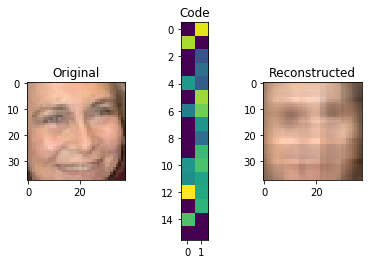

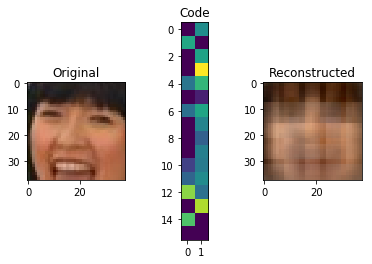

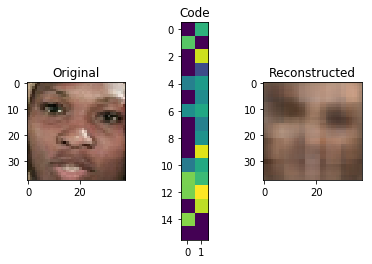

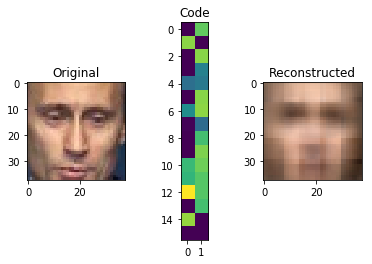

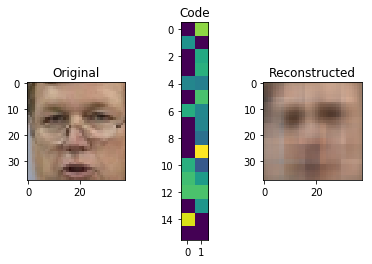

In [63]:
auto_encoder.train(epochs=32)
auto_encoder.visualize()

These are really blocky, let's try with a bigger amount of filters.

last img output shape:  (None, 3, 3, 64)
Adding layer <keras.layers.core.Dense object at 0x7f8e93fa63c8>
Adding layer <keras.layers.core.Dense object at 0x7f8e93ffc5c0>
Adding layer <keras.layers.core.Reshape object at 0x7f8e93febc50>
Adding layer <keras.layers.convolutional.UpSampling2D object at 0x7f8e93feb710>
Adding layer <keras.layers.convolutional.Conv2DTranspose object at 0x7f8e93fcbac8>
Adding layer <keras.layers.convolutional.UpSampling2D object at 0x7f8e93fcb470>
Adding layer <keras.layers.convolutional.Conv2DTranspose object at 0x7f8e9805d710>
Adding layer <keras.layers.convolutional.UpSampling2D object at 0x7f8e98016048>
Adding layer <keras.layers.convolutional.Conv2DTranspose object at 0x7f8e98105ef0>
Adding layer <keras.layers.core.Reshape object at 0x7f8e980ae400>
Train on 11828 samples, validate on 1315 samples
Epoch 1/16
11828/11828 [==============================] - 8s 694us/step - loss: 0.0255 - val_loss: 0.0171
Epoch 2/16
11828/11828 [==============================]

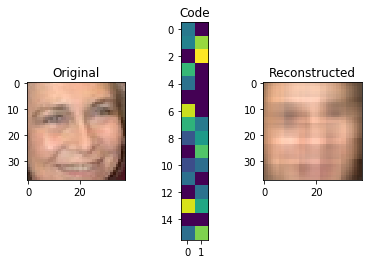

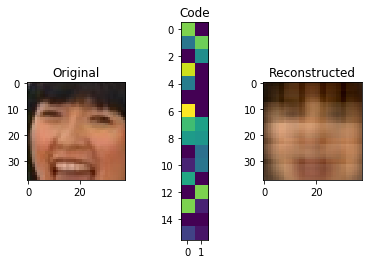

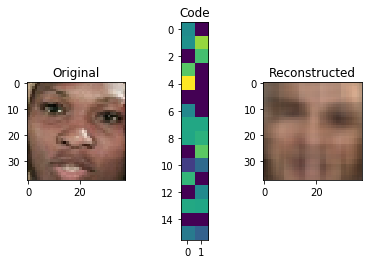

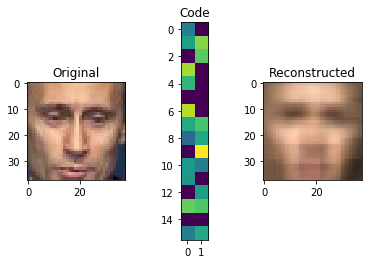

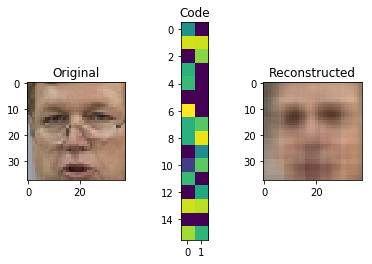

In [64]:
s.close()
s = tf.Session()
K.set_session(s)

code_size=32

auto_encoder = AutoEncoder(img_shape=img_shape, code_size=code_size)

filters = 64

auto_encoder.add_conv_layer(filters, size=3)
auto_encoder.add_max_pool()
auto_encoder.add_conv_layer(filters, size=3)
auto_encoder.add_max_pool()
auto_encoder.add_conv_layer(filters, size=3)
auto_encoder.add_max_pool()

print("last img output shape: ", auto_encoder.last_encoder_node.output_shape)

auto_encoder.add_flatten()
hidden_size = code_size * 4

# auto_encoder.add_dense(hidden_size, activity_regularizer=regularizers.l1(10e-5))
# auto_encoder.add_dense(hidden_size, activity_regularizer=regularizers.l1(10e-5))

auto_encoder.add_dense(128)
auto_encoder.add_dense(code_size)

auto_encoder.train(epochs=16)
auto_encoder.visualize()


In [65]:
auto_encoder.train(epochs=32)
auto_encoder.visualize()

Train on 11828 samples, validate on 1315 samples
Epoch 1/32
11828/11828 [==============================] - 6s 503us/step - loss: 0.0095 - val_loss: 0.0095
Epoch 2/32
11828/11828 [==============================] - 5s 450us/step - loss: 0.0095 - val_loss: 0.0095
Epoch 3/32
11828/11828 [==============================] - 5s 450us/step - loss: 0.0095 - val_loss: 0.0094
Epoch 4/32
11828/11828 [==============================] - 5s 444us/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/32
11828/11828 [==============================] - 5s 449us/step - loss: 0.0094 - val_loss: 0.0094
Epoch 6/32
11828/11828 [==============================] - 5s 446us/step - loss: 0.0094 - val_loss: 0.0094
Epoch 7/32
11828/11828 [==============================] - 5s 446us/step - loss: 0.0094 - val_loss: 0.0093
Epoch 8/32
11828/11828 [==============================] - 5s 449us/step - loss: 0.0094 - val_loss: 0.0094
Epoch 9/32
11828/11828 [==============================] - 5s 453us/step - loss: 0.0094 - val_loss: 0.00

KeyboardInterrupt: 

Final MSE: 0.0093093427401


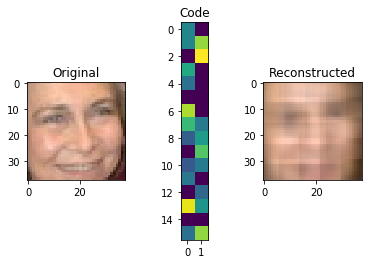

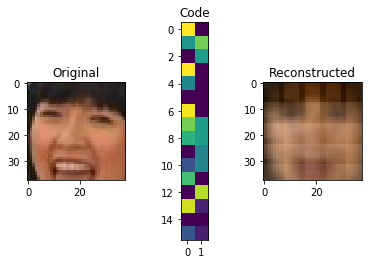

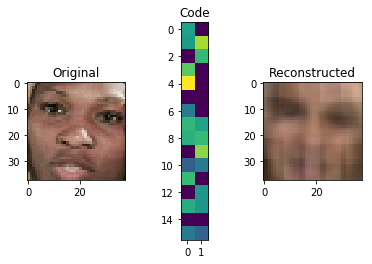

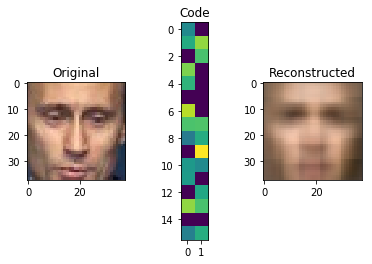

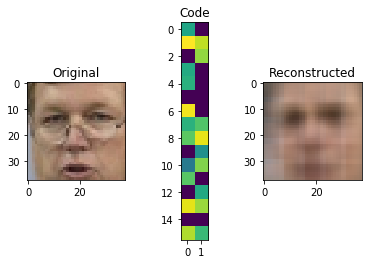

In [66]:
auto_encoder.visualize()

This is still very very blocky. Let's try without pooling layers.

In [ ]:
s.close()
s = tf.Session()
K.set_session(s)

code_size=32

auto_encoder = AutoEncoder(img_shape=img_shape, code_size=code_size)

filters = 64

auto_encoder.add_conv_layer(filters, size=3)
auto_encoder.add_conv_layer(filters, size=3)
auto_encoder.add_conv_layer(filters, size=3)

print("last img output shape: ", auto_encoder.last_encoder_node.output_shape)

auto_encoder.add_flatten()
hidden_size = code_size * 4

# auto_encoder.add_dense(hidden_size, activity_regularizer=regularizers.l1(10e-5))
# auto_encoder.add_dense(hidden_size, activity_regularizer=regularizers.l1(10e-5))

auto_encoder.add_dense(128)
auto_encoder.add_dense(code_size)

auto_encoder.train(epochs=16)
auto_encoder.visualize()


last img output shape:  (None, 32, 32, 64)
Adding layer <keras.layers.core.Dense object at 0x7f8e99a0ecf8>
Adding layer <keras.layers.core.Dense object at 0x7f8e999cd400>
Adding layer <keras.layers.core.Reshape object at 0x7f8e99a209e8>
Adding layer <keras.layers.convolutional.Conv2DTranspose object at 0x7f8e99a18630>
Adding layer <keras.layers.convolutional.Conv2DTranspose object at 0x7f8e99a38cf8>
Adding layer <keras.layers.convolutional.Conv2DTranspose object at 0x7f8e991c0940>
Adding layer <keras.layers.core.Reshape object at 0x7f8e99148f60>
Train on 11828 samples, validate on 1315 samples
Epoch 1/16
11828/11828 [==============================] - 21s 2ms/step - loss: 0.0381 - val_loss: 0.0144
Epoch 2/16
 2080/11828 [====>.........................] - ETA: 14s - loss: 0.0141

Adding layer <keras.layers.core.Dense object at 0x7f8ed1ae7048>
Adding layer <keras.layers.core.Dense object at 0x7f8ed1a89278>
Adding layer <keras.layers.core.Dense object at 0x7f8ed1c58080>
Adding layer <keras.layers.core.Reshape object at 0x7f8ed1ac9710>
Adding layer <keras.layers.core.Reshape object at 0x7f8ed1ac3a58>
Train on 11828 samples, validate on 1315 samples
Epoch 1/64
11828/11828 [==============================] - 3s 261us/step - loss: 0.0785 - val_loss: 0.0560
Epoch 2/64
11828/11828 [==============================] - 3s 227us/step - loss: 0.0442 - val_loss: 0.0364
Epoch 3/64
11828/11828 [==============================] - 3s 228us/step - loss: 0.0322 - val_loss: 0.0290
Epoch 4/64
11828/11828 [==============================] - 3s 226us/step - loss: 0.0267 - val_loss: 0.0246
Epoch 5/64
11828/11828 [==============================] - 3s 218us/step - loss: 0.0230 - val_loss: 0.0217
Epoch 6/64
11828/11828 [==============================] - 3s 217us/step - loss: 0.0207 - val_loss

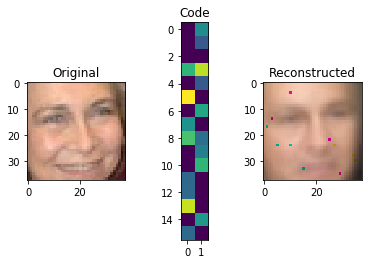

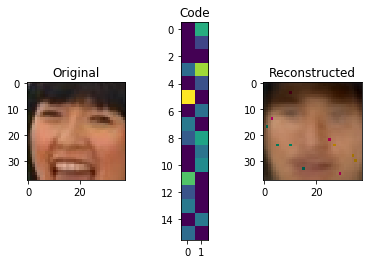

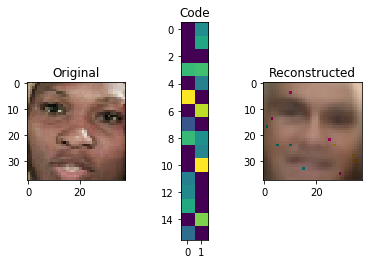

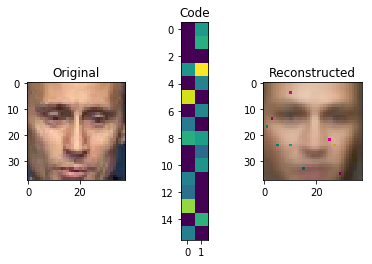

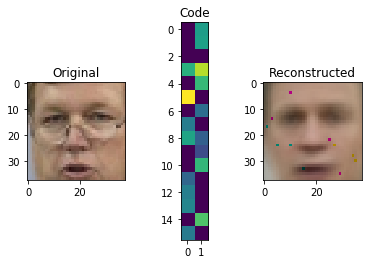

In [20]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=32)
autoencoder = train_deep_autoencoder(encoder, decoder, batch_size=32)
visualize_autoencoder(encoder, decoder, autoencoder)

In [ ]:
import keras.backend as K
from keras import regularizers

s.close()
s = tf.Session()
K.set_session(s)

def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    
    encoder = keras.models.Sequential()
    input_node = L.InputLayer(img_shape)
    encoder.add(input_node)

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    decoder_layers = [L.Reshape(img_shape)]

    conv_filters = 32
    hidden_size = code_size * 2
    
    prev_filters = 3
    last_encoder_node = input_node
    
    def add_conv_layer(filters, size):
        nonlocal prev_filters
        nonlocal last_encoder_node
        
        conv = L.Conv2D(filters, (size, size), activation='relu', padding="same")
        encoder.add(conv)
        last_encoder_node = conv
        decoder_layers.append(L.Deconv2D(prev_filters, (size, size), activation='relu', padding="same"))
        prev_filters = filters
        return conv
        
    def add_max_pool():
        nonlocal prev_filters
        nonlocal last_encoder_node

        maxpool2d = L.MaxPooling2D((2,2), padding="valid")
        encoder.add(maxpool2d)
        print("Added encoder MaxPooling2D layer, input_shape: {}, output_shape: {}".format(maxpool2d.input_shape, maxpool2d.output_shape))
        last_encoder_node = maxpool2d
        decoder_layers.append(L.UpSampling2D((2,2)))
        return maxpool2d
    
    def add_dense(size, 
                  encoder_activation='relu', 
                  decoder_activation='relu',
                 activity_regularizer=None):
        nonlocal prev_filters
        nonlocal last_encoder_node

        dense = L.Dense(size, activation=encoder_activation,
                       activity_regularizer=activity_regularizer)
        encoder.add(dense)
        last_encoder_node = dense
        decoder_layers.append(L.Dense(dense.input_shape[1], activation=decoder_activation))
        
            
    add_conv_layer(17, size=3)
    add_conv_layer(33, size=3)
    add_max_pool()
    add_conv_layer(63, size=3)
    add_conv_layer(128, size=3)
#     add_max_pool()
    
    print("last img output shape: ", last_encoder_node.output_shape)
 
    flat1 = L.Flatten()
    encoder.add(flat1)
    decoder_layers.append(L.Reshape(last_encoder_node.output_shape[1:]))

#     add_dense(hidden_size, activity_regularizer=regularizers.l1(10e-5))
#     add_dense(hidden_size, activity_regularizer=regularizers.l1(10e-5))
    add_dense(code_size)

    for layer in reversed(decoder_layers):
        print("Adding layer", layer)
        decoder.add(layer)
        print("Layer input shape: {}, output shape: {}".format(layer.input_shape, layer.output_shape))
    
    return encoder,decoder

encoder,decoder = build_deep_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

autoencoder.fit(x=X_train,y=X_train,epochs=64,batch_size=2000,
                validation_data=[X_test,X_test])

In [ ]:
autoencoder.fit(x=X_train,y=X_train,epochs=64,batch_size=2000,shuffle=True,
                validation_data=[X_test,X_test])

In [ ]:
import keras.backend as K
from keras import regularizers

s.close()
s = tf.Session()
K.set_session(s)

def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    
    encoder = keras.models.Sequential()
    input_node = L.InputLayer(img_shape)
    encoder.add(input_node)

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    decoder_layers = [L.Reshape(img_shape)]

    conv_filters = 32
    hidden_size = code_size * 2
    
    prev_filters = 3
    last_encoder_node = input_node
    
    def add_conv_layer(filters, size):
        nonlocal prev_filters
        nonlocal last_encoder_node
        
        conv = L.Conv2D(filters, (size, size), activation='relu', padding="same")
        encoder.add(conv)
        last_encoder_node = conv
        decoder_layers.append(L.Deconv2D(prev_filters, (size, size), activation='relu', padding="same"))
        prev_filters = filters
        return conv
        
    def add_max_pool():
        nonlocal prev_filters
        nonlocal last_encoder_node

        maxpool2d = L.MaxPooling2D((2,2), padding="valid")
        encoder.add(maxpool2d)
        print("Added encoder MaxPooling2D layer, input_shape: {}, output_shape: {}".format(maxpool2d.input_shape, maxpool2d.output_shape))
        last_encoder_node = maxpool2d
        decoder_layers.append(L.UpSampling2D((2,2)))
        return maxpool2d
    
    def add_dense(size, 
                  encoder_activation='relu', 
                  decoder_activation='relu',
                 activity_regularizer=None):
        nonlocal prev_filters
        nonlocal last_encoder_node

        dense = L.Dense(size, activation=encoder_activation,
                       activity_regularizer=activity_regularizer)
        encoder.add(dense)
        last_encoder_node = dense
        decoder_layers.append(L.Dense(dense.input_shape[1], activation=decoder_activation))
        
            
    add_conv_layer(64, size=3)
    add_conv_layer(16, size=3)
    add_max_pool()

    print("last img output shape: ", last_encoder_node.output_shape)
 
    flat1 = L.Flatten()
    encoder.add(flat1)
    decoder_layers.append(L.Reshape(last_encoder_node.output_shape[1:]))
    
    encoder.add(L.Dropout(0.5))

    add_dense(code_size)

    for layer in reversed(decoder_layers):
        print("Adding layer", layer)
        decoder.add(layer)
        print("Layer input shape: {}, output shape: {}".format(layer.input_shape, layer.output_shape))
    
    return encoder,decoder

encoder,decoder = build_deep_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

autoencoder.fit(x=X_train,y=X_train,epochs=64,batch_size=2000,
                validation_data=[X_test,X_test])


In [ ]:
autoencoder.fit(x=X_train,y=X_train,epochs=100,batch_size=2000,shuffle=True,
                validation_data=[X_test,X_test])

In [ ]:
import keras.backend as K
from keras import regularizers

s.close()
s = tf.Session()
K.set_session(s)

def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    
    encoder = keras.models.Sequential()
    input_node = L.InputLayer(img_shape)
    encoder.add(input_node)

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    decoder_layers = [L.Reshape(img_shape)]

    conv_filters = 32
    hidden_size = code_size * 2
    
    prev_filters = 3
    last_encoder_node = input_node
    
    def add_conv_layer(filters, size):
        nonlocal prev_filters
        nonlocal last_encoder_node
        
        conv = L.Conv2D(filters, (size, size), activation='relu', padding="same")
        encoder.add(conv)
        last_encoder_node = conv
        decoder_layers.append(L.Deconv2D(prev_filters, (size, size), activation='relu', padding="same"))
        prev_filters = filters
        return conv
        
    def add_max_pool():
        nonlocal prev_filters
        nonlocal last_encoder_node

        maxpool2d = L.MaxPooling2D((2,2), padding="valid")
        encoder.add(maxpool2d)
        print("Added encoder MaxPooling2D layer, input_shape: {}, output_shape: {}".format(maxpool2d.input_shape, maxpool2d.output_shape))
        last_encoder_node = maxpool2d
        decoder_layers.append(L.UpSampling2D((2,2)))
        return maxpool2d
    
    def add_dense(size, 
                  encoder_activation='relu', 
                  decoder_activation='relu',
                 activity_regularizer=None):
        nonlocal prev_filters
        nonlocal last_encoder_node

        dense = L.Dense(size, activation=encoder_activation,
                       activity_regularizer=activity_regularizer)
        encoder.add(dense)
        last_encoder_node = dense
        decoder_layers.append(L.Dense(dense.input_shape[1], activation=decoder_activation))
        
            
    add_conv_layer(64, size=3)
    add_conv_layer(16, size=3)
    add_max_pool()

    print("last img output shape: ", last_encoder_node.output_shape)
 
    flat1 = L.Flatten()
    encoder.add(flat1)
    decoder_layers.append(L.Reshape(last_encoder_node.output_shape[1:]))
    
    decoder_layers.append(L.LeakyReLU())
    add_dense(code_size * 2)
    encoder.add(L.LeakyReLU())

    decoder_layers.append(L.LeakyReLU())
    add_dense(code_size * 2)
    encoder.add(L.LeakyReLU())
    encoder.add(L.Dropout(0.5))

    decoder_layers.append(L.LeakyReLU())
    add_dense(code_size)

    for layer in reversed(decoder_layers):
        print("Adding layer", layer)
        decoder.add(layer)
        print("Layer input shape: {}, output shape: {}".format(layer.input_shape, layer.output_shape))
    
    return encoder,decoder

encoder,decoder = build_deep_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

autoencoder.fit(x=X_train,y=X_train,epochs=64,batch_size=2000,
                validation_data=[X_test,X_test])


In [ ]:
reconstruction_mse = autoencoder.evaluate(X_test,X_test,verbose=0)
# assert reconstruction_mse <= 0.005, "Compression is too lossy. See tips below."
print("mse: {}".format(reconstruction_mse))
assert len(encoder.output_shape)==2 and encoder.output_shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [ ]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    <your code here>
        
    return X + noise
    

In [ ]:
#noise tests
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

In [ ]:
plt.subplot(1,4,1)
plt.imshow(X[0])
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0])

In [ ]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [ ]:
for i in range(50):
    print("Epoch %i/50, Generating corrupted samples..."%i)
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    autoencoder.fit(x=X_train_noise,y=X_train,epochs=1,
                    validation_data=[X_test_noise,X_test])

__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

In [ ]:
denoising_mse = autoencoder.evaluate(apply_gaussian_noise(X_test),X_test,verbose=0)
print("Final MSE:", denoising_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [ ]:
encoder.save("./encoder.h5")
decoder.save("./decoder.h5")

### Submit to Coursera

In [ ]:
from submit import submit_autoencoder
submission = build_deep_autoencoder(img_shape,code_size=71)
submit_autoencoder(submission, reconstruction_mse, 2<email>, <token>)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [ ]:
images = X_train
codes = <encode all images>
assert len(codes) == len(images)

In [ ]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [ ]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
#smiles
show_similar(X_test[2])

In [ ]:
#ethnicity
show_similar(X_test[500])

In [ ]:
#glasses
show_similar(X_test[66])

## Bonus: cheap image morphing


In [ ]:

for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1,image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        plt.imshow(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.